# HANC with a Welfare State

In [1]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

from HANCWelfareModel import HANCWelfareModelClass
from steady_state import obj_ss

## Model without a Governement

I import the model and draw the DAG

In [2]:
model = HANCWelfareModelClass(name='baseline')
par = model.par
ss = model.ss

production_firm: [K,L] -> [rK,w,Y]
mutual_fund: [K,rK] -> [A,r]
government: [L,w] -> [B,G,Lg,wt]
hh: [r,w,wt] -> [A_hh,C_hh,ELL_hh,L_hh,INC_hh,U_hh,S_hh]
market_clearing: [A,A_hh,L,Lg,L_hh,Y,C_hh,K] -> [I,clearing_A,clearing_L,clearing_Y]


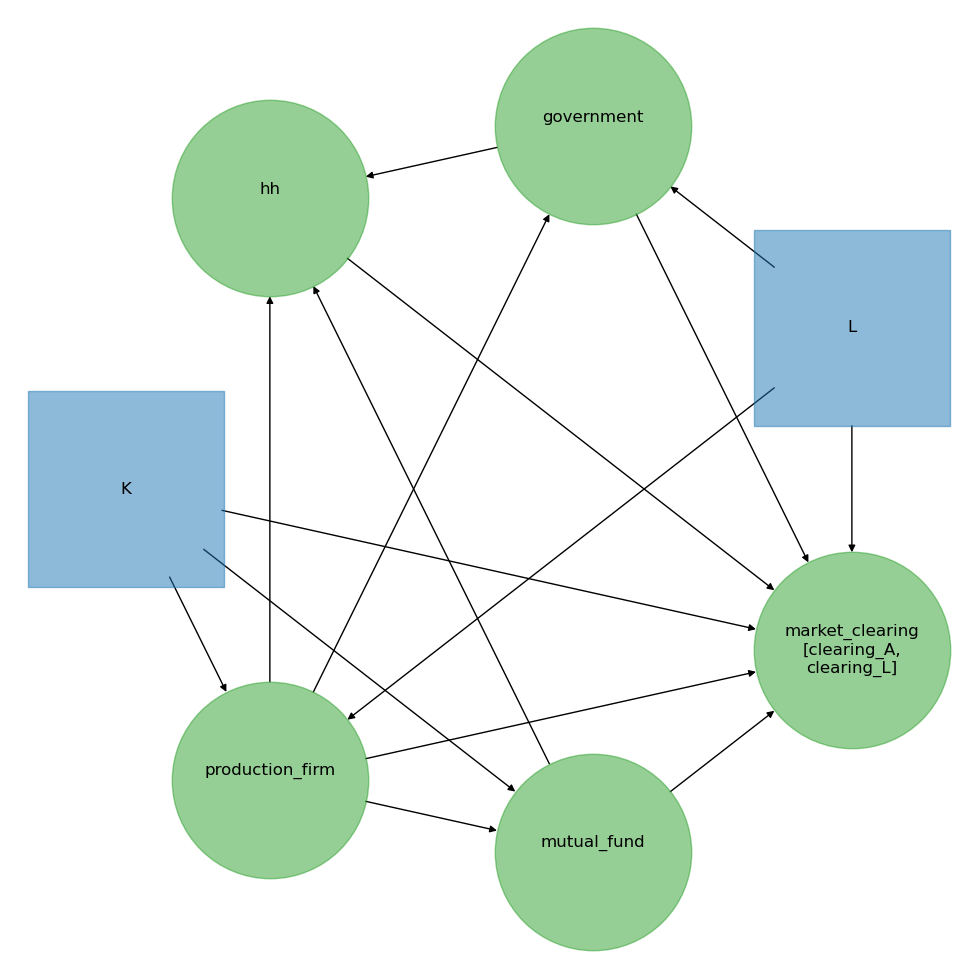

In [3]:
model.info(only_blocks=True)
model.draw_DAG()

I set all the steady values for the household problem manually at ad hoc values and now solve and simulate:

In [4]:
ss.r = 0.02*(1-0.1)
ss.wt = 1.00*(1-0.3)
ss.w = ss.wt/(1-par.tau_ss)

In [5]:
model.solve_hh_ss(do_print=True)
model.simulate_hh_ss(do_print=True)

household problem in ss solved in 0.3 secs [345 iterations]
household problem in ss simulated in 1.0 secs [399 iterations]


And check whether the results make sort of sense:

In [6]:
print(f'{model.ss.A_hh = :.2f}')
print(f'{model.ss.L_hh = :.2f}')
print(f'{model.ss.C_hh = :.2f}')

model.ss.A_hh = 2.03
model.ss.L_hh = 1.06
model.ss.C_hh = 0.78


The results seem to make sense and thus I will now solve for the steady state in the model with no Gorvernment.

In [7]:
#setting values to zero to remove government
model.par.tau_ss = 0.0
model.par.chi_ss = 0.0

#simulating the steady state
model.find_ss(do_print=True)

starting at [3.8624]

 message: The solution converged.
 success: True
  status: 1
     fun: 6.981082378842984e-13
       x: [ 3.673e+00]
    nfev: 8
    fjac: [[-1.000e+00]]
       r: [-8.480e+00]
     qtf: [-6.223e-08]

steady state found in 2.7 secs
ss.K =  3.389
ss.B =  0.000
ss.A_hh =  3.389
ss.L =  0.923
ss.Lg =  0.000
ss.Y =  1.363
ss.G =  0.000
ss.r =  0.021
ss.w =  1.034
ss.wt =  1.034
ss.clearing_A = 6.98e-13
ss.clearing_L = 0.00e+00
ss.clearing_Y = 1.29e-10


I see we find a steady state where we see there is no government (ss.G=ss.Lg=0). Testing the stationary equilibrium I find

In [8]:
model.test_path()

shocks: 
unknowns: K L 

blocks.production_firm
 rK               0.0e+00
 w                0.0e+00
 Y                0.0e+00
blocks.mutual_fund
 A                0.0e+00
 r                0.0e+00
blocks.government
 B                0.0e+00
 G                0.0e+00
 Lg               0.0e+00
 wt               0.0e+00
hh
 A_hh             2.7e-09
 C_hh             7.7e-11
 ELL_hh           1.2e-10
 L_hh             1.0e-10
 INC_hh           4.9e-11
 U_hh             1.9e-10
 S_hh             0.0e+00
blocks.market_clearing
 I                0.0e+00
 clearing_A       2.7e-09 [target]
 clearing_L       1.0e-10 [target]
 clearing_Y       7.7e-11


note: inputs = steady state value -> expected: constant value (straigt line)

household problem solved along transition path in 0.3 secs
household problem simulated along transition in 0.0 secs



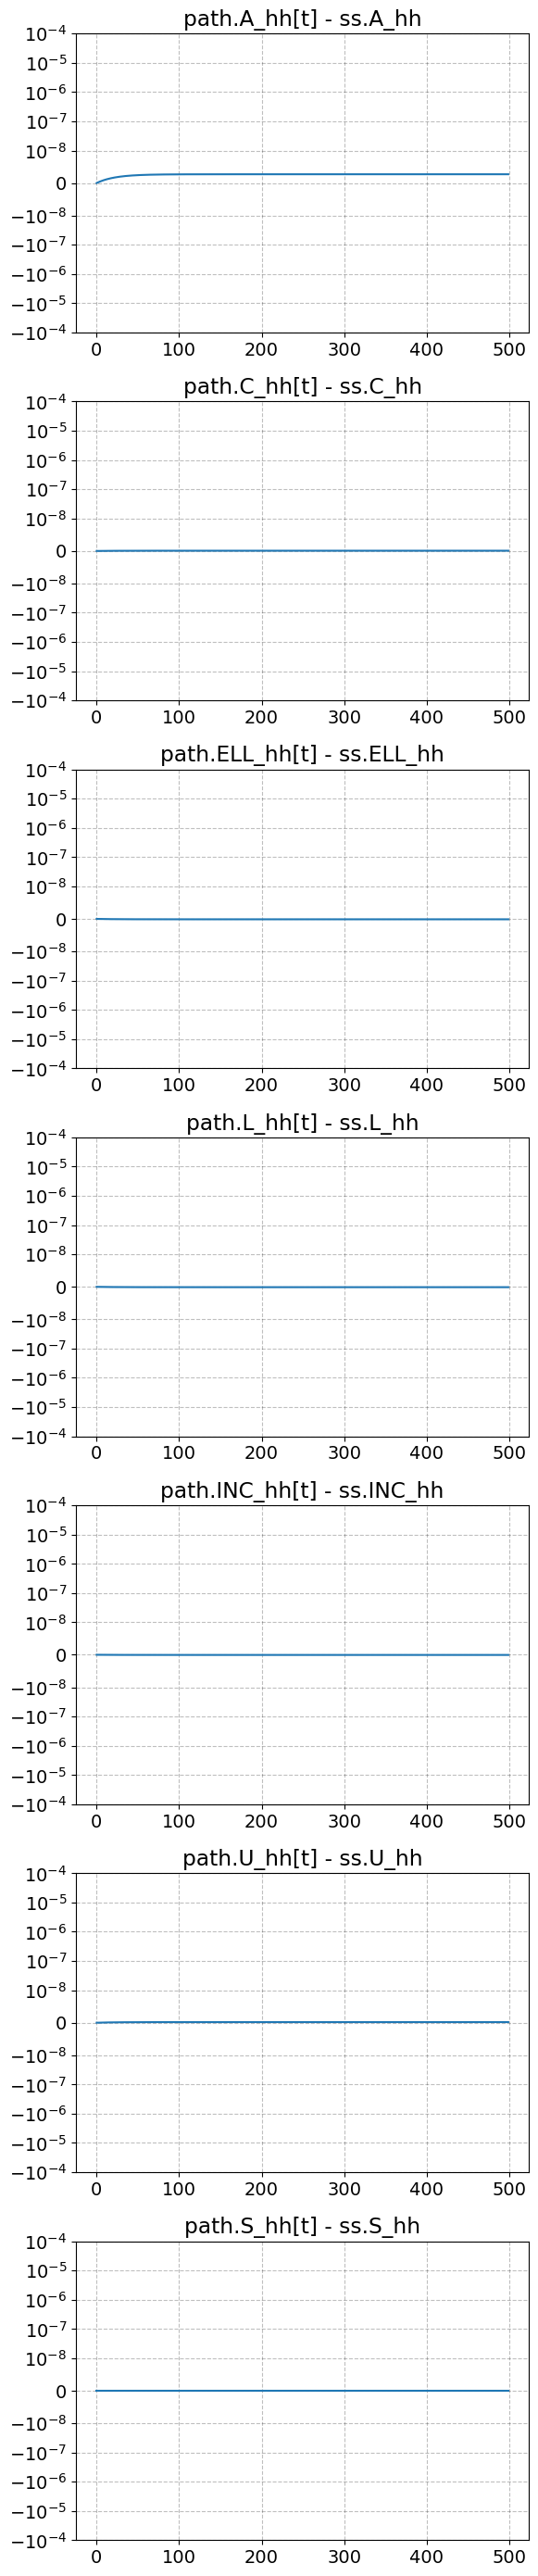

In [9]:
model.test_hh_path()

And we see that the steady state is indeed a stationary equilibrium.

I can therefore calculate the expected utility of the household in the steady state:

In [10]:
util_no_govern = np.sum([par.beta**t * ((np.sum((ss.u+(ss.G+par.S)**(1-par.omega)/(1-par.omega)) * ss.D / (np.sum(ss.D))))) for t in range(par.T)])
print(f'{util_no_govern = :.2f}')

util_no_govern = -2500000037.03


We see that the expected utility is very negavtive in the case of no Governement in the model. This is because the household is not insured against the risk of unemployment and thus the household is very exposed to the risk of unemployment. This is also why the household chooses to work a lot in the steady state.

## Optimal welfare policy with only taxes on labour income

I start by creating a new instance of our baseline model

In [11]:
modelI = HANCWelfareModelClass(name='baseline')

par = modelI.par
ss = modelI.ss

To find the optimal policy with only a tax on labour income, $\tau$, I first define the objective function of the planner:

In [12]:
def objI(tau):
    par.tau_ss = tau
    modelI.find_ss()
    return -np.sum([par.beta**t * ((np.sum((ss.u+(ss.G+par.S)**(1-par.omega)/(1-par.omega)) * ss.D / (np.sum(ss.D))))) for t in range(par.T)])

Next I use a scalar minimizer to find the optimal tax rate on labour income:

In [13]:
optI = optimize.minimize_scalar(objI,bounds=(0.0,0.99),method='bounded')

In [14]:
optI

 message: Solution found.
 success: True
  status: 0
     fun: 138.9680295616232
       x: 0.6551037720343537
     nit: 10
    nfev: 10

Thus I find the optimal tax on labour as $\tau=65.51\%$.

Adding this to the model and solving for the steady state I find:

In [15]:
par.tau_ss = optI.x
modelI.find_ss(do_print=True)

starting at [3.8624]

 message: The solution converged.
 success: True
  status: 1
     fun: -1.9539925233402755e-14
       x: [ 3.435e+00]
    nfev: 12
    fjac: [[-1.000e+00]]
       r: [-9.034e+00]
     qtf: [-2.227e-11]

steady state found in 4.3 secs
ss.K =  2.897
ss.B =  0.000
ss.A_hh =  2.897
ss.L =  0.843
ss.Lg =  0.415
ss.Y =  1.221
ss.G =  0.415
ss.r =  0.026
ss.w =  1.014
ss.wt =  0.350
ss.clearing_A = -1.95e-14
ss.clearing_L = 0.00e+00
ss.clearing_Y = 1.14e-10


The Goverment spending output ratio can therefore be calculated as:

In [16]:
print(f'{ss.G/ss.Y = :.4f}')

ss.G/ss.Y = 0.3398


## Optimal welfare policy with taxes on labour income and lumpsum transfers

I again create a new instance of the baseline model

In [17]:
modelII = HANCWelfareModelClass(name='baseline')

par = modelII.par
ss = modelII.ss

To find the optimal policy with a tax on labour income and lumpsum transfers I again define the objective function of the planner:

In [18]:
def objII(tau,chi):
    par.tau_ss = tau
    par.chi_ss = chi
    modelII.find_ss()
    return -np.sum([par.beta**t * ((np.sum((ss.u+(ss.G+par.S)**(1-par.omega)/(1-par.omega)) * ss.D / (np.sum(ss.D))))) for t in range(par.T)])

As this no longer is a problem of 1 dimension I use a multivariate minimizer to find the optimal tax rate on labour income and lumpsum transfers. I will start the search in the old optimum (optI):

In [19]:
optII = optimize.minimize(lambda x: objII(x[0],x[1]),x0=(optI.x,0.0),method='Nelder-Mead')

In [20]:
optII

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 136.88928465891496
             x: [ 4.766e-01 -2.182e-01]
           nit: 43
          nfev: 83
 final_simplex: (array([[ 4.766e-01, -2.182e-01],
                       [ 4.767e-01, -2.181e-01],
                       [ 4.766e-01, -2.182e-01]]), array([ 1.369e+02,  1.369e+02,  1.369e+02]))

Thus the optimal taxrate in this case is $\tau = 47.66\%$ and the optimal lumpsum transfer is $\chi = -0.2181$ implying a lumpsum tax.

In [21]:
modelII.par.tau_ss = optII.x[0]
modelII.par.chi_ss = optII.x[1]
modelII.find_ss(do_print=True)

starting at [3.8624]

 message: The solution converged.
 success: True
  status: 1
     fun: 1.0835776720341528e-13
       x: [ 3.676e+00]
    nfev: 8
    fjac: [[-1.000e+00]]
       r: [-8.356e+00]
     qtf: [-2.102e-08]

steady state found in 2.9 secs
ss.K =  3.479
ss.B =  0.000
ss.A_hh =  3.479
ss.L =  0.946
ss.Lg =  0.444
ss.Y =  1.399
ss.G =  0.444
ss.r =  0.021
ss.w =  1.034
ss.wt =  0.541
ss.clearing_A = 1.08e-13
ss.clearing_L = 0.00e+00
ss.clearing_Y = 1.32e-10


The Goverment spending output ratio can therefore be calculated as:

In [22]:
print(f'{ss.G/ss.Y = :.4f}')

ss.G/ss.Y = 0.3177


## Model with increased TFP and Government

I once again create a new instance of the model and repeat the same steps as before but with $\Gamma^Y = 1.1$:

In [23]:
modelIII = HANCWelfareModelClass(name='baseline')

par = modelIII.par
ss = modelIII.ss

par.Gamma_Y = 1.1

In [24]:
def objIII(tau,chi):
    par.tau_ss = tau
    par.chi_ss = chi
    modelIII.find_ss()
    return -np.sum([par.beta**t * ((np.sum((ss.u+(ss.G+par.S)**(1-par.omega)/(1-par.omega)) * ss.D / (np.sum(ss.D))))) for t in range(par.T)])

In [25]:
optIII = optimize.minimize(lambda x: objIII(x[0],x[1]),x0=(optII.x[0],optII.x[1]),method='Nelder-Mead')

In [26]:
par.tau_ss = optIII.x[0]
par.chi_ss = optIII.x[1]
modelIII.find_ss(do_print=True)

starting at [4.4258]

 message: The solution converged.
 success: True
  status: 1
     fun: 2.220446049250313e-15
       x: [ 4.231e+00]
    nfev: 8
    fjac: [[-1.000e+00]]
       r: [-7.713e+00]
     qtf: [-5.649e-09]

steady state found in 2.9 secs
ss.K =  3.731
ss.B =  0.000
ss.A_hh =  3.731
ss.L =  0.882
ss.Lg =  0.465
ss.Y =  1.495
ss.G =  0.465
ss.r =  0.020
ss.w =  1.187
ss.wt =  0.615
ss.clearing_A = 2.22e-15
ss.clearing_L = 0.00e+00
ss.clearing_Y = 1.45e-10


In [27]:
print(f'{ss.G/ss.Y = :.4f}')

ss.G/ss.Y = 0.3112
